# 🧠 PyTorch Neural Network Training
====================================

Step-by-step exploration of the `pytorch_network.py` implementation for robot navigation.

**What you'll learn:**
- PyTorch neural network architecture and training
- Configuration management with YAML
- Model evaluation and performance analysis


## 1. Setup and Data Loading


In [14]:
# Setup and imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Import our custom modules
from core.pytorch_network import RobotNavigationNet, RobotNavigationTrainer, load_config, create_data_loaders
from core.data_generation import load_training_data

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Setup complete!")
print(f"🖥️  PyTorch version: {torch.__version__}")
print(f"🔧 Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

# Load configuration and data
config = load_config()
data_path = project_root / "data" / "raw" / "small_training_dataset.npz"

try:
    X, y, metadata = load_training_data(data_path)
    print(f"\n✅ Data loaded: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"📊 Action distribution: {np.bincount(y)}")
except FileNotFoundError:
    print(f"❌ Data file not found: {data_path}")
    print("💡 Run 'python scripts/generate_data.py small' first")

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X, y,
    batch_size=config['training']['batch_size'],
    train_ratio=config['data']['train_ratio'],
    val_ratio=config['data']['val_ratio'],
    test_ratio=config['data']['test_ratio']
)

print(f"📊 Data splits: Train={len(train_loader.dataset)}, Val={len(val_loader.dataset)}, Test={len(test_loader.dataset)}")


✅ Setup complete!
🖥️  PyTorch version: 2.8.0
🔧 Device: CPU
✅ Configuration loaded from /Users/omkar/Documents/GitHub/AI_Projects/Robot-Navigation/configs/nn_config.yaml
📂 Training data loaded from /Users/omkar/Documents/GitHub/AI_Projects/Robot-Navigation/data/raw/small_training_dataset.npz

✅ Data loaded: 874 samples, 9 features
📊 Action distribution: [243 170 209 252]
📊 Data splits:
   Train: 698 samples
   Validation: 88 samples
   Test: 88 samples
📊 Data splits: Train=698, Val=88, Test=88


## 2. Model Architecture


In [15]:
# Create model
model = RobotNavigationNet(
    input_size=config['model']['input_size'],
    hidden1_size=config['model']['hidden1_size'],
    hidden2_size=config['model']['hidden2_size'],
    output_size=config['model']['output_size'],
    dropout_rate=config['model']['dropout_rate']
)

# Get architecture info
info = model.get_architecture_info()
print("🧠 Neural Network Architecture:")
print(f"   Architecture: {info['architecture']}")
print(f"   Total parameters: {info['total_parameters']:,}")
print(f"   Trainable parameters: {info['trainable_parameters']:,}")
print(f"   Dropout rate: {info['dropout_rate']}")

# Show model structure
print("\n🔍 Model Structure:")
print(model)


🧠 Neural Network Architecture:
   Architecture: 9 → 64 → 32 → 4
   Total parameters: 2,852
   Trainable parameters: 2,852
   Dropout rate: 0.2

🔍 Model Structure:
RobotNavigationNet(
  (fc1): Linear(in_features=9, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)


## 3. Training


In [16]:
# Create trainer
trainer = RobotNavigationTrainer(
    model=model,
    learning_rate=config['training']['learning_rate']
)

print("✅ Model and trainer created!")
print(f"📊 Training configuration:")
print(f"   Learning rate: {config['training']['learning_rate']}")
print(f"   Batch size: {config['training']['batch_size']}")
print(f"   Max epochs: {config['training']['epochs']}")
print(f"   Early stopping patience: {config['training']['early_stopping']['patience']}")

# Train the model
print(f"\n🏋️ Starting training...")
history = trainer.train(
    train_loader, val_loader,
    epochs=config['training']['epochs'],
    early_stopping_patience=config['training']['early_stopping']['patience']
)

print(f"\n✅ Training completed!")
print(f"📊 Final results:")
print(f"   Best validation accuracy: {max(history['val_accuracies']):.4f}")
print(f"   Best validation loss: {min(history['val_losses']):.4f}")
print(f"   Training epochs: {len(history['train_losses'])}")


✅ Model and trainer created!
📊 Training configuration:
   Learning rate: 0.001
   Batch size: 32
   Max epochs: 100
   Early stopping patience: 15

🏋️ Starting training...
🚀 Starting training on cpu
🧠 Architecture: 9 → 64 → 32 → 4
⚙️  Learning rate: 0.001
🛡️  Dropout rate: 0.2
------------------------------------------------------------
Epoch   0: Train Loss=1.3845, Train Acc=26.65%, Val Loss=1.3772, Val Acc=38.64%
Epoch  10: Train Loss=1.2611, Train Acc=48.57%, Val Loss=1.2642, Val Acc=43.18%
Epoch  20: Train Loss=1.2383, Train Acc=49.57%, Val Loss=1.2703, Val Acc=43.18%
🛑 Early stopping at epoch 26 (patience=15)
✅ Training completed! Best validation loss: 1.2618

✅ Training completed!
📊 Final results:
   Best validation accuracy: 45.4545
   Best validation loss: 1.2618
   Training epochs: 27


## 4. Training Visualization


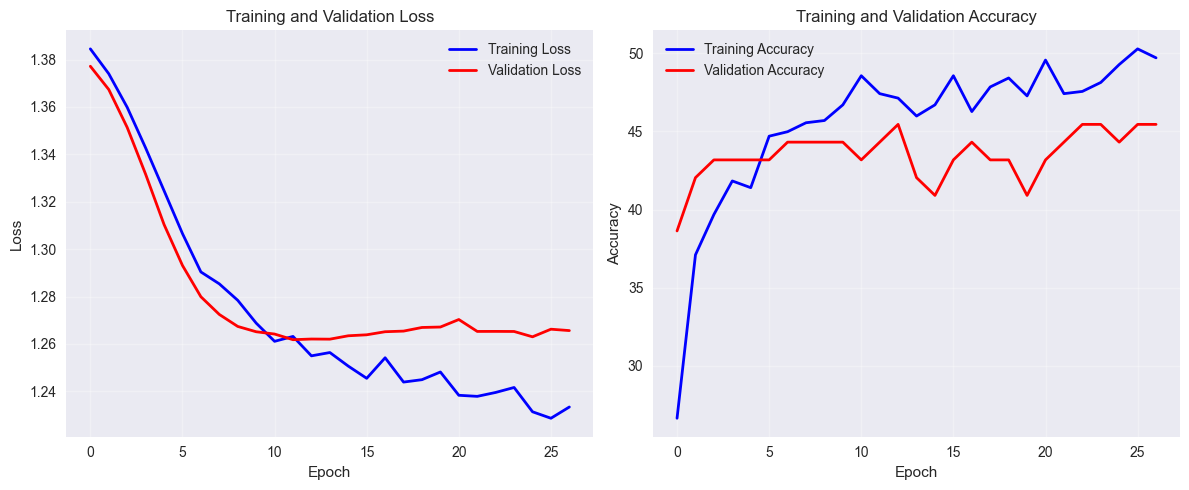


🔍 Training Analysis:
   Training Accuracy: 49.7135 (4971.3%)
   Validation Accuracy: 45.4545 (4545.5%)
   Overfitting: 4.2589 (425.9%)
⚠️  Warning: Significant overfitting detected!


In [17]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
axes[0].plot(history['train_losses'], label='Training Loss', color='blue', linewidth=2)
axes[0].plot(history['val_losses'], label='Validation Loss', color='red', linewidth=2)
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_accuracies'], label='Training Accuracy', color='blue', linewidth=2)
axes[1].plot(history['val_accuracies'], label='Validation Accuracy', color='red', linewidth=2)
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze results
final_train_acc = history['train_accuracies'][-1]
final_val_acc = history['val_accuracies'][-1]
overfitting = final_train_acc - final_val_acc

print(f"\n🔍 Training Analysis:")
print(f"   Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
print(f"   Overfitting: {overfitting:.4f} ({overfitting*100:.1f}%)")

if overfitting > 0.1:
    print(f"⚠️  Warning: Significant overfitting detected!")
elif overfitting < -0.05:
    print(f"✅ Good: Model is not overfitting")
else:
    print(f"✅ Acceptable: Minimal overfitting")


## 5. Model Evaluation


📊 Test Set Performance:
   Test Accuracy: 1.2264 (122.6%)
   Test Loss: 48.8636


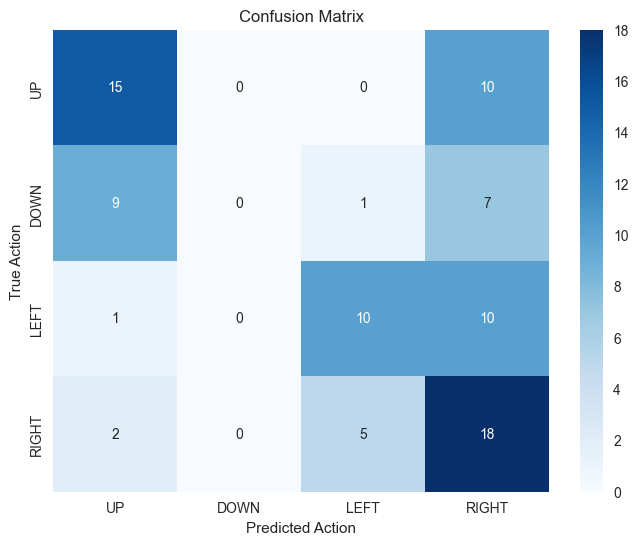


📋 Classification Report:
              precision    recall  f1-score   support

          UP       0.56      0.60      0.58        25
        DOWN       0.00      0.00      0.00        17
        LEFT       0.62      0.48      0.54        21
       RIGHT       0.40      0.72      0.51        25

    accuracy                           0.49        88
   macro avg       0.40      0.45      0.41        88
weighted avg       0.42      0.49      0.44        88



In [18]:
# Evaluate on test set
test_accuracy, test_loss = trainer.evaluate(test_loader)
print(f"📊 Test Set Performance:")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"   Test Loss: {test_loss:.4f}")

# Get predictions for confusion matrix
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Create confusion matrix
action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']
cm = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=action_names, yticklabels=action_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Action')
plt.ylabel('True Action')
plt.show()

# Print classification report
print(f"\n📋 Classification Report:")
print(classification_report(all_targets, all_predictions, target_names=action_names))


## 6. Summary

**What you've learned:**
- ✅ PyTorch neural network architecture (9→64→32→4)
- ✅ Configuration management with YAML
- ✅ Training process with early stopping
- ✅ Performance evaluation and visualization

**Key insights:**
- ReLU activation prevents vanishing gradients
- Dropout helps prevent overfitting
- Early stopping saves training time
- Confusion matrix shows prediction patterns
